<a href="https://colab.research.google.com/github/nitinsaimajji/voice1/blob/main/voice_detection_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install python_speech_features module

In [1]:
pip install python_speech_features


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5889 sha256=96a3cad0efbdda77e42fa4576b7bb210185a29110809d0a2ec41974ecfa545fa
  Stored in directory: /root/.cache/pip/wheels/5b/60/87/28af2605138deac93d162904df42b6fdda1dab9b8757c62aa3
Successfully built python_speech_features


In [2]:
!git clone https://github.com/nitinsaimajji/voice1.git

Cloning into 'voice1'...
remote: Enumerating objects: 681, done.
remote: Counting objects: 100% (681/681), done.
remote: Compressing objects: 100% (648/648), done.
remote: Total 681 (delta 34), reused 670 (delta 29), pack-reused 0
Receiving objects: 100% (681/681), 152.55 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (1208/1208), done.


In [3]:
pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all modules

In [5]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from python_speech_features import mfcc
from time import time

## **A1**

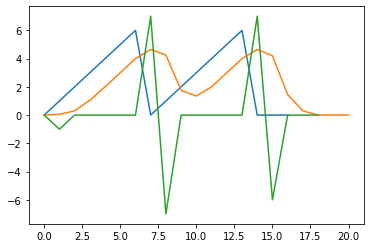

In [6]:
X=[0,1,2,3,4,5,6,0,1,2,3,4,5,6,0,0,0]
H_L=[0.05,0.2,0.5,0.2,0.05]
H_H=[-1,2,-1]
y_low=np.convolve(X,H_L)
y_high=np.convolve(X,H_H)
plt.plot(X)
plt.plot(y_low)
plt.plot(y_high)

## A2

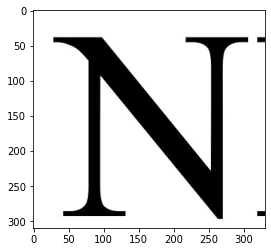

In [7]:
from scipy import signal 
from skimage.io import imread
from skimage.color import rgb2gray
im=imread(r"/content/voice1/Neural.JPG")
img=rgb2gray(im)*255
plt.imshow(img,cmap='gray')
img1=img[40:350,20:350]
plt.imshow(img1,cmap='gray')
plt.show()

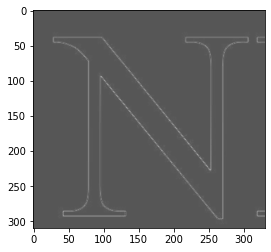

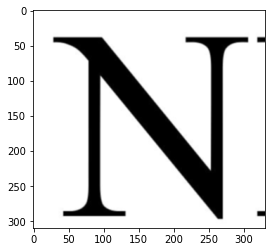

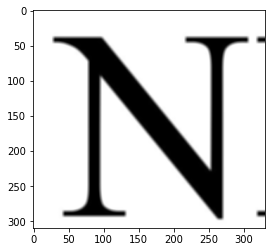

In [8]:
fil1=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
fil2=np.array([[0.2,0.5,0.2],[0.5,1,0.5],[0.2,0.5,0.2]])
fil3=np.array([[0.1,0.1,0.1,0.1,0.1],[0.1,0.1,0.1,0.1,0.1],[0.1,0.1,0.1,0.1,0.1],[0.1,0.1,0.1,0.1,0.1],[0.1,0.1,0.1,0.1,0.1]])
grad1=signal.convolve2d(img1,fil1,boundary='symm',mode='same')
grad2=signal.convolve2d(img1,fil2,boundary='symm',mode='same')
grad3=signal.convolve2d(img1,fil3,boundary='symm',mode='same')

grad=[grad1,grad2,grad3]

plt.imshow(abs(grad1),cmap='gray',vmin=np.min(grad),vmax=np.max(grad))
plt.show()

plt.imshow(grad2,cmap='gray')
plt.show()
plt.imshow(grad3,cmap='gray')

Load the csv file into data frame

In [ ]:
df = pd.read_csv('/content/voice1/wav_check.csv')
df.count

<bound method DataFrame.count of                      filename  gender
0      male-sample-000008.wav    male
1      male-sample-000014.wav    male
2      male-sample-000019.wav    male
3      male-sample-000020.wav    male
4      male-sample-000023.wav    male
..                        ...     ...
195  female-sample-001164.wav  female
196  female-sample-001193.wav  female
197  female-sample-001194.wav  female
198  female-sample-001216.wav  female
199  female-sample-001237.wav  female

[200 rows x 2 columns]>

Create two new data frames

In [ ]:
df_male = df[df['gender']=='male']
df_female = df[df['gender']=='female']


Find out the number of rows

In [ ]:
print(df_male.shape)		


(100, 2)


In [ ]:
print(df_female.shape)		
print(df_female)


(100, 2)
                     filename  gender
100  female-sample-000013.wav  female
101  female-sample-000026.wav  female
102  female-sample-000034.wav  female
103  female-sample-000039.wav  female
104  female-sample-000051.wav  female
..                        ...     ...
195  female-sample-001164.wav  female
196  female-sample-001193.wav  female
197  female-sample-001194.wav  female
198  female-sample-001216.wav  female
199  female-sample-001237.wav  female

[100 rows x 2 columns]


Taking only 200 male and 200 female data

In [ ]:
df_male = df_male[:200]
df_female = df_female[:200]

Define the audio path

In [ ]:
TRAIN_PATH = '/content/voice/cv-valid-train/'

The function to convert mp3 to wav

In [ ]:
def convert_to_wav(df, m_f, path=TRAIN_PATH):
    srcs = []
    for file in tqdm(df['filename']):
        sound = AudioSegment.from_mp3(path+file)
        
		# Create new wav files based on existing mp3 files
        if m_f == 'male':
            sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        elif m_f == 'female':
            sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
    return

In [ ]:
convert_to_wav(df_female, m_f='female')
convert_to_wav(df_male, m_f='male')

100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


In [ ]:
TRAIN_PATH = '/content/voice1/dataset1/'

Define a function to load the raw audio files

In [ ]:
def load_audio(path=TRAIN_PATH):
    male_voices = []
    female_voices = []
    for file in tqdm(df['filename']):
        if file.split('-')[0] == 'male':
            male_voices.append(librosa.load(path+file))
        elif file.split('-')[0] == 'female':
            female_voices.append(librosa.load(path+file))
    
    male_voices = np.array(male_voices)
    female_voices = np.array(female_voices)
    
    return male_voices, female_voices

In [ ]:
def convert_to_wav(df, m_f, path=TRAIN_PATH):
    srcs = []
    for file in tqdm(df['filename']):
        sound = AudioSegment.from_mp3(path+file)
        
		# Create new wav files based on existing mp3 files
        if m_f == 'male':
            sound.export('male-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        elif m_f == 'female':
            sound.export('female-'+file.split('/')[-1].split('.')[0]+'.wav', format='wav')
        
    return

How to use load_audio() function

In [ ]:
male_voices, female_voices = load_audio()

100%|██████████| 200/200 [00:26<00:00,  7.42it/s]
<ipython-input-36-1eec0c28e137>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  male_voices = np.array(male_voices)
<ipython-input-36-1eec0c28e137>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  female_voices = np.array(female_voices)


The function to extract audio features

In [ ]:
def extract_features(audio_data):
	audio_waves = audio_data[:,0]
	samplerate = audio_data[:,1][1]
	
	features = []
	for audio_wave in tqdm(audio_waves):
		features.append(mfcc(audio_wave, samplerate=samplerate, numcep=26))
    
	features = np.array(features)
	return features

Use the extract_features() function

In [ ]:
male_features = extract_features(male_voices)
female_features = extract_features(female_voices)

100%|██████████| 100/100 [00:01<00:00, 89.85it/s]
<ipython-input-39-1d3dd38f60c7>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(features)
100%|██████████| 100/100 [00:01<00:00, 87.85it/s]


The function used to concatenate all audio features forming a long 2-dimensional array

In [ ]:
def concatenate_features(audio_features):
    concatenated = audio_features[0]
    for audio_feature in tqdm(audio_features):
        concatenated = np.vstack((concatenated, audio_feature))
        
    return concatenated

How the function is used

In [ ]:
male_concatenated = concatenate_features(male_features)
female_concatenated = concatenate_features(female_features)

100%|██████████| 100/100 [00:00<00:00, 3491.79it/s]


In [ ]:
print(male_concatenated.shape) 		


(40177, 26)


In [ ]:
print(female_concatenated.shape)	


(40816, 26)


Concatenate male voices and female voices

In [ ]:
X = np.vstack((male_concatenated, female_concatenated))
X=X[0:100000]

Create labels

In [ ]:
y = np.append([0] * len(male_concatenated), [1] * len(female_concatenated))
y=y[0:100000]

Check whether X and y are already having the exact same length

In [ ]:
print(X.shape)		


(80993, 26)


In [ ]:
print(y.shape)		

(80993,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=22)

In [ ]:
X_train.shape

(51835, 26)

MLP

In [ ]:
import keras
from keras.models import Sequential
from keras. layers import Dense, Dropout, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(400,activation='relu',input_dim=26))
model.add(Dense(200,activation='relu'))
model.add(Dense(20,activation='softmax'))

sgd=SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1620/1620 [==============================] - 5s 3ms/step - loss: 0.5727 - accuracy: 0.7149 - val_loss: 0.4955 - val_accuracy: 0.7561
Epoch 2/20
1620/1620 [==============================] - 4s 2ms/step - loss: 0.4885 - accuracy: 0.7604 - val_loss: 0.4930 - val_accuracy: 0.7621
Epoch 3/20
1620/1620 [==============================] - 5s 3ms/step - loss: 0.4524 - accuracy: 0.7830 - val_loss: 0.4602 - val_accuracy: 0.7819
Epoch 4/20
1620/1620 [==============================] - 4s 3ms/step - loss: 0.4257 - accuracy: 0.7996 - val_loss: 0.4355 - val_accuracy: 0.7953
Epoch 5/20
1620/1620 [==============================] - 5s 3ms/step - loss: 0.4092 - accuracy: 0.8085 - val_loss: 0.4564 - val_accuracy: 0.7902
Epoch 6/20
1620/1620 [==============================] - 4s 3ms/step - loss: 0.3894 - accuracy: 0.8179 - val_loss: 0.4432 - val_accuracy: 0.7967
Epoch 7/20
1620/1620 [==============================] - 4s 3ms/step - loss: 0.3729 - accuracy: 0.8283 - val_loss: 0.4441 - val_accuracy:

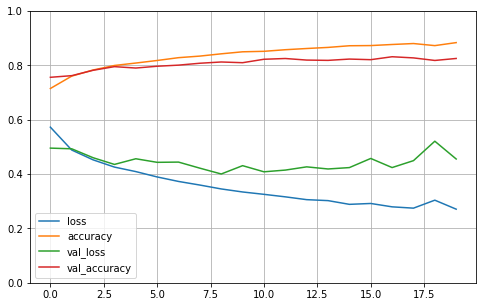

1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.
2. If the validation loss is greater than the training loss,The model is overfitting.
3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit


In [ ]:
## when using 200 samples of each male and female

import pandas as pd
import numpy as np
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print('1. If the validation loss is greater(are both high:) than the training loss. The model is underfitting.')
print('2. If the validation loss is greater than the training loss,The model is overfitting.')
print('3. If the training loss and validation loss both decrease and stabilize at a specific point:the model is good fit')


In [ ]:
X_new = X_test[:5]
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 33ms/step


array([0, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
accuracy = accuracy_score(y_test[:5],y_pred)*100
print("accuracy is "+str(accuracy))

accuracy is 40.0
